<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%204/Laboratorio_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




## Integrantes

*   Juan José Villegas
*   Juan Sebastián Méndez



## Taller
## Segundo Problema

Ante la gran demanda de noticias que se generan hoy en día, el servicio público de radio y televisión Británica BBC desea realizar un sistema que le permita clasificar diferentes noticias para mostrarlas en su página web. Para ello, le ha brindado las noticias previamente clasificadas en cinco categorías.

Se propone como ejercicio:

1. Realizar ***un clasificador utilizando un MLP*** para la solución de este problema.
2. Realizar una tabla comparando los resultados de los modelos del taller 4 con los arrojados por el ***MLP***.


# 1. Importando las librerias requeridas

In [1]:
import pandas as pd
import numpy as np
import contractions
import inflect
import re, string, unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_profiling import ProfileReport
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [2]:
import nltk
# Download punkt if not installed
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juansebastianmendezrubiano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juansebastianmendezrubiano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juansebastianmendezrubiano/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Perfilamiento y entendimiento de los datos

## 2.1 Adquisición de datos

In [3]:
# Usamos la función load_files de sklearn para cargar todas las noticias en sus respectivas categorías.
news_bunch = load_files("./Punto 2/Noticias BBC", load_content=True, encoding='utf-8', decode_error='ignore')
categories = news_bunch.target_names
categories

['business', 'entertainment', 'politics', 'sport', 'tech']

In [4]:
# Transformamos los datos obtenidos por load_files en un dataframe de pandas.
news = pd.DataFrame(news_bunch.data, news_bunch.target, columns=["text"])
news.reset_index(level=0, inplace=True)
news['class'] = news['index'].apply(lambda x: categories[x])
del news['index']

news['word_count'] = [len(x) for x in news['text']]
news['mode'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in news['text']]
news['max'] = [[max([len(x) for x in i.split(' ')])][0] for i in news['text']]
news['min'] = [[min([len(x) for x in i.split(' ')])][0] for i in news['text']]

news.head()

,text,class,word_count,mode,max,min
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,1118,the,19,1
1,Halo 2 sells five million copies\n\nMicrosoft ...,tech,1846,the,21,1
2,MSPs hear renewed climate warning\n\nClimate c...,politics,1731,the,22,1
3,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,775,the,13,1
4,Tories reject rethink on axed MP\n\nSacked MP ...,politics,3298,the,18,1


In [5]:
ProfileReport(news)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


# 3. Preparación de datos

Al igual que en el laboratorio pasado, vamos a hacer los pasos estándar para limpiar los datos y dejarlos listos para nuestro algoritmo:

 1. Eliminamos contracciones usando "Contractions" (Por ejemplo, i'm -> I am). Un programa en python que lo hace por nosotros.
 1. Luego hacemos una tokenización de los textos. Es decir, hacemos una lista con todas las palabras encontradas en cada texto.
 1. Luego hacemos un preprocesamiento de los datos. Esto incluye:
    1. Remover caractéres que no son ASCII.
    1. Pasar todas las palabras a minúsculas.
    1. Remover puntuación.
    1. Reemplazar números por su representación en palabras.
    1. Quitar las stopwords en inglés.
 

In [6]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [7]:
news['text'] = news['text'].apply(contractions.fix) #Aplica la corrección de las contracciones
news['words'] = news['text'].apply(word_tokenize)
news['words'] = news['words'].apply(preproccesing) #Aplica la eliminación del ruido
news.head()

,text,class,word_count,mode,max,min,words
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,1118,the,19,1,"[tate, lyle, boss, bags, top, award, tate, lyl..."
1,Halo 2 sells five million copies\n\nMicrosoft ...,tech,1846,the,21,1,"[halo, two, sells, five, million, copies, micr..."
2,MSPs hear renewed climate warning\n\nClimate c...,politics,1731,the,22,1,"[msps, hear, renewed, climate, warning, climat..."
3,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,775,the,13,1,"[pavey, focuses, indoor, success, jo, pavey, m..."
4,Tories reject rethink on axed MP\n\nSacked MP ...,politics,3298,the,18,1,"[tories, reject, rethink, axed, mp, sacked, mp..."


Ahora que los datos están un poco más limpios, nos preparamos para hacer Stemming y Lematización. Para esto utilizamos soluciones estándar como el LancasterStemmer, y el WordNetLemmatizer.

In [8]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

news['words'] = news['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
news.head()

,text,class,word_count,mode,max,min,words
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,1118,the,19,1,"[tat, lyl, boss, bag, top, award, tat, lyl, ch..."
1,Halo 2 sells five million copies\n\nMicrosoft ...,tech,1846,the,21,1,"[halo, two, sel, fiv, mil, cop, microsoft, cel..."
2,MSPs hear renewed climate warning\n\nClimate c...,politics,1731,the,22,1,"[msps, hear, renew, clim, warn, clim, chang, c..."
3,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,775,the,13,1,"[pavey, focus, indo, success, jo, pavey, miss,..."
4,Tories reject rethink on axed MP\n\nSacked MP ...,politics,3298,the,18,1,"[tory, reject, rethink, ax, mp, sack, mp, howa..."


In [9]:
X, y = news['words'],news['class']

In [10]:
news['words'] = news['words'].apply(lambda x: ' '.join(map(str, x)))
news

,text,class,word_count,mode,max,min,words
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,1118,the,19,1,tat lyl boss bag top award tat lyl chief execu...
1,Halo 2 sells five million copies\n\nMicrosoft ...,tech,1846,the,21,1,halo two sel fiv mil cop microsoft celebr bump...
2,MSPs hear renewed climate warning\n\nClimate c...,politics,1731,the,22,1,msps hear renew clim warn clim chang could com...
3,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,775,the,13,1,pavey focus indo success jo pavey miss janu vi...
4,Tories reject rethink on axed MP\n\nSacked MP ...,politics,3298,the,18,1,tory reject rethink ax mp sack mp howard fligh...
...,...,...,...,...,...,...,...
2220,EU fraud clampdown urged\n\nEU member states a...,politics,2470,the,17,1,eu fraud clampdown urg eu memb stat fail repor...
2221,Tindall aiming to earn Lions spot\n\nBath and ...,sport,1232,to,13,1,tindal aim earn lion spot bath england cent mi...
2222,Jamelia's return to the top\n\nR&B star Jameli...,entertainment,2196,the,19,1,jamel return top r b star jamel three brit nom...
2223,Oscars steer clear of controversy\n\nThe Oscar...,entertainment,3801,the,21,1,osc ste clear controversy osc nomin list left ...


In [11]:
# Convertimos nuestras 5 categorias a 5 columnas dummy
y = pd.get_dummies(y)
y

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,1,0,0
...,...,...,...,...,...
2220,0,0,1,0,0
2221,0,0,0,1,0
2222,0,1,0,0,0
2223,0,1,0,0,0


In [12]:
# Convertimos nuestra columna de words en una matríz dispersa usando TfidfVectorizer
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X)
print(X_tf_idf.shape)
X_tf_idf.toarray()[0]

(2225, 36725)


array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
n_input = (X_tf_idf.shape)[1]
n_output = (y.shape)[1]
print('input:', n_input)
print('output:', n_output)

input: 36725
output: 5


# 4. Modelamiento

In [14]:
# Utilizamos un callback de early stopping con una "paciencia" de 3.
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

El modelo lo construimos modificando ligeramente la función original para agregar la tasa de aprendizaje que se utiliza en el optimizador (SGD). Igualmente, para poder comparar con nuestra implementación del laboratorio anterior, decidimos correr el RandomizedSearch con la función de scoring por defecto (accuracy).

In [15]:
def build_model(n_hidden=1, n_neurons_1 = 100, n_neurons_2 = 100, dropout = 0.1, activation_hidden = 'relu', learning_rate=3e-3):
    clf = Sequential(name='lab_5')
    first = True

    for layer in range(n_hidden):
        if first:
            clf.add(Dense(n_neurons_1, activation=activation_hidden, name=f'hidden_layer_{layer}'))
            first = False
        else:
            clf.add(Dense(n_neurons_2, activation=activation_hidden, name=f'hidden_layer_{layer}'))
    
    clf.add(Dropout(dropout,name=f'dropout_layer_{dropout}'))
    clf.add(Dense(n_output, activation='sigmoid', name= 'output_layer'))

    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    clf.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
    
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=build_model, epochs=20, batch_size=20, verbose=1,shuffle = True)

In [16]:
class toArray():
    def __init__(self):
        return

    def transform(self, X, **transform_params):
        return X.toarray()

    def fit(self, X, y=None, **fit_params):
        return self

In [17]:
pipe = Pipeline([('transformation',TfidfVectorizer()), ('matrix',toArray()), ('neural_network',modelCV)])

param_grid = dict(transformation=[TfidfVectorizer(),CountVectorizer()],
                  neural_network__n_hidden = [1,2],
                  neural_network__n_neurons_1 = [100, 512, 10000],
                  neural_network__n_neurons_2 = [100, 512, 10000],
                  neural_network__dropout = [0.1,0.2,0.3],
                  neural_network__activation_hidden = ['relu','sigmoid'],
                  neural_network__learning_rate = [0.03, 0.1, 0.3]
                  )

grid = RandomizedSearchCV(pipe, param_grid, verbose=1, cv = 3, n_iter=10, random_state=20)

In [18]:
Xtext_train, Xtext_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=33)
grid.fit(Xtext_train, y_train, neural_network__callbacks=callbacks)

best_model = grid.best_estimator_

===] - 0s 5ms/step - loss: 1.4851 - accuracy: 0.4836
Epoch 20/20
30/30 [==============================] - 0s 3ms/step - loss: 1.4705 - accuracy: 0.5430
Epoch 1/20
60/60 [==============================] - 27s 450ms/step - loss: 0.6790 - accuracy: 0.6703
Epoch 2/20
60/60 [==============================] - 27s 450ms/step - loss: 0.0518 - accuracy: 0.9882
Epoch 3/20
60/60 [==============================] - 27s 448ms/step - loss: 0.0693 - accuracy: 0.9848
Epoch 4/20
60/60 [==============================] - 27s 451ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 5/20
60/60 [==============================] - 27s 450ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 6/20
60/60 [==============================] - 27s 449ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 7/20
60/60 [==============================] - 27s 452ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 8/20
60/60 [==============================] - 27s 449ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 9/20
60/60 [======================

In [24]:
print(grid.best_params_)
print(best_model)
best_model['neural_network'].model.save("lab5.h5")
best_model['neural_network'].model.summary()

{'transformation': TfidfVectorizer(), 'neural_network__n_neurons_2': 10000, 'neural_network__n_neurons_1': 10000, 'neural_network__n_hidden': 2, 'neural_network__learning_rate': 0.1, 'neural_network__dropout': 0.2, 'neural_network__activation_hidden': 'relu'}
Pipeline(steps=[('transformation', TfidfVectorizer()),
                ('matrix', <__main__.toArray object at 0x151b13090>),
                ('neural_network',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x151afdc90>)])
Model: "lab_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       multiple                  334180000 
_________________________________________________________________
hidden_layer_1 (Dense)       multiple                  100010000 
_________________________________________________________________
dropout_layer_0.2 (Dropout)  multiple                  0       

Como podemos ver arriba, nuestra mejor versión está dada por una red neuronal de dos capas, cada una con 10000 neuronas, una capa de dropout con una probabilidad de 0.2, una tasa de aprendizaje de 0.1 para el optimizador SGD, y una función de activación, para ambas capas ocultas, RELU.

# 5. Predicción

In [20]:
y_pred_train = best_model.predict(Xtext_train)
y_pred_text = best_model.predict(Xtext_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
23/23 [==============================] - 3s 120ms/step


# 6. Validación

In [21]:
Y_train = y_train.argmax(axis=-1)
Y_test = y_test.argmax(axis=-1)
print('Resultados sobre train')
print(classification_report(Y_train, y_pred_train, target_names=y.columns))
print('Resultados sobre test')
print(classification_report(Y_test, y_pred_text, target_names=y.columns))

Resultados sobre train
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       410
entertainment       1.00      1.00      1.00       309
     politics       1.00      1.00      1.00       332
        sport       1.00      1.00      1.00       404
         tech       1.00      1.00      1.00       325

     accuracy                           1.00      1780
    macro avg       1.00      1.00      1.00      1780
 weighted avg       1.00      1.00      1.00      1780

Resultados sobre test
               precision    recall  f1-score   support

     business       0.99      0.98      0.98       100
entertainment       0.97      0.97      0.97        77
     politics       0.99      0.96      0.98        85
        sport       0.99      1.00      1.00       107
         tech       0.95      0.97      0.96        76

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg  

Text(50.713125000000005, 0.5, 'predicted label')

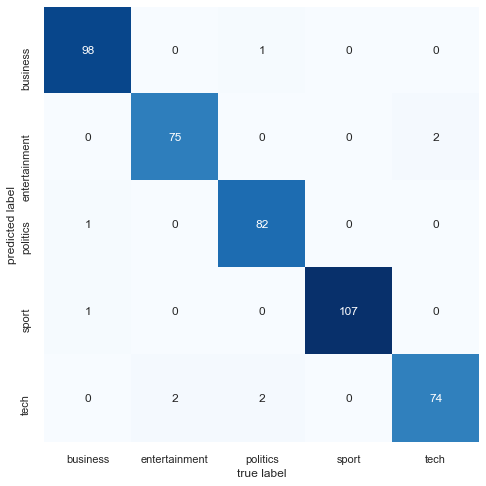

In [22]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_text)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y.columns,
            yticklabels=y.columns)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Conclusiones:

* Reutilizamos el preprocesamiento de datos utilizado en el laboratorio anterior ya que los resultados fueron satisfactorios.
* Keras es relativamente fácil de usar. Permite crear redes neuronales de manera sencilla y tiene su forma de unir la lógica con el poderoso Grid/Random search de sci-kit learn para el afinamiento de los hiperparámetros.
* Las redes neuronales no demoran tanto entrenando como otros algoritmos usados durante el curso como SVM.
* Este tipo de topologías, en redes neuronales, arrojan resultados realmente buenos, llegando a tener precisión y recall perfecto para el conjunto de entrenamiento sin haber quedado sobreajustado. El conjunto de test obtuvo puntajes de hasta el 99% de precisión y un accuracy del 98%.
* Se hizo el laboratorio con diferentes computadores, unos usando la versión CPU de tensorflow, y otro utilizando la versión GPU. Pudimos ver que la versión con GPU ejecuta mucho más rápido que la versión CPU. Mientras el RandomizedSearch toma 2 horas (aproximadamente) con CPU, aún con un intel core i9, esta misma función toma 6 minutos en GPU (NVidia GeForce GTX 1060).